# **exactly-once delivery strategy**


## **Messaging sementics**

카프카와 같은 메시징 시스템은 특정 수준의 메시지 보증 전략을 가지고 있다.

- **at-most-once** : 실패나 타임아웃 등이 발생하면 메시지를 버릴 수 있다. 데이터가 일부 누락되더라도 영향이 없는 경우엔 대량처리 및 짧은 주기의 전송 서비스에 유용할 수 있다.

- **exactly-once** : 메시지가 정확하게 한 번만 전달되는 것을 보장한다. 손실이나 중복 없이, 순서대로 메시지를 전송하는 것은 구현 난이도가 높고 비용이 많이 든다.

- **at-least-once** : 메시지가 최소 1번 이상 전달되는 것을 보장한다. 실패나 타임아웃 등이 발생하면 메시지를 다시 전송하며, 이 경우엔 동일한 메시지가 중복으로 처리될 수 있다.

exactly-once가 가장 이상적인 메시지 처리 방식이지만 난이도와 비용으로 인해 at-least-once로 타협하는 경우가 보편적이다. Kafka의 경우 at-least-once를 보장하며 일정 버전 이후에서만 옵션을 통해 exactly-once를 적용할 수 있다.


## **Kafka의 at-least-once 구현**

Kafka의 경우 Producer가 메시지를 전송하고 나서 Broker로부터 ack를 받는 수준을 조절함으로써 **at-least-once**를 보장할 수 있다.

- **ack=0** : Producer가 메시지 전송 후, ack를 기다리지 않고 바로 다음 메시지를 전송한다. 만약 Broker가 다운된다면 이 기간 동안 전송된 메시지들은 모두 손실된다. 메시지가 손실되더라도 빠른 전송이 필요한 경우에 사용할 수 있다.

- **ack=1** : Producer가 메시지 전송 후, partition leader로부터 일정시간 ack를 기다린다. 손실 가능성이 적고 적당한 전송 속도를 가지게 된다. ack 전송 직후 partition leader의 Broker가 follower들이 복사해가기 전에 다운되면 해당 메시지는 손실된다.

- **ack=all** : Producer가 메시지 전송 후, partition의 leader, follower 모두로부터 ack를 기다린다. 손실이 없지만 전송 속도가 느리다.



##  **Kafka에서 메시지가 중복 처리되는 경우**

Kafka에서 메시지들은 순차적으로 증가하는 offset 값을 가지고 순서대로 추가된다. 
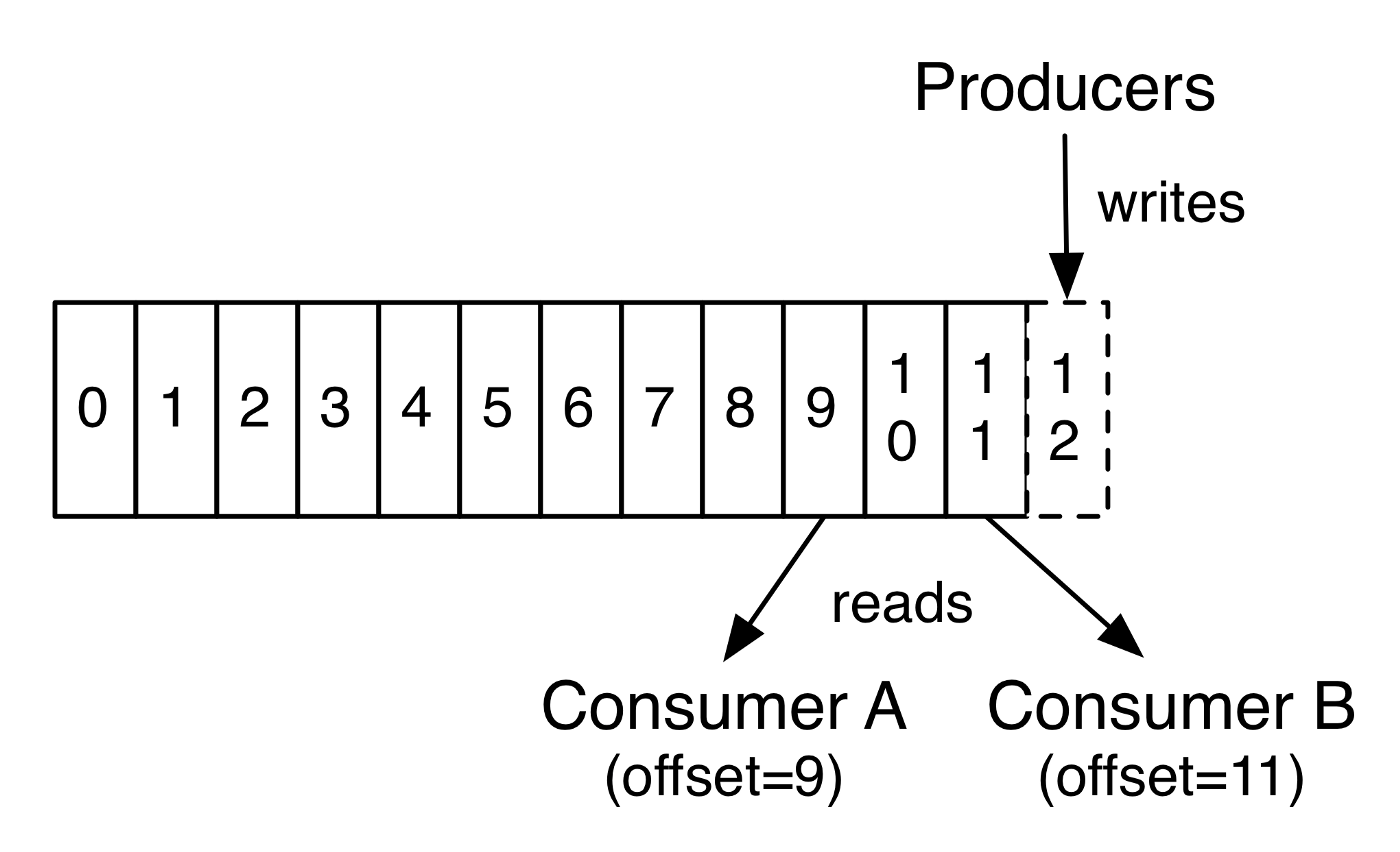

Producer는 Kafka에 메시지를 입력하고, Consumer는 메시지를 읽어 DB 등의 저장소에 저장한다. 이 경우 다음과 같은 파이프라인이 형성된다.
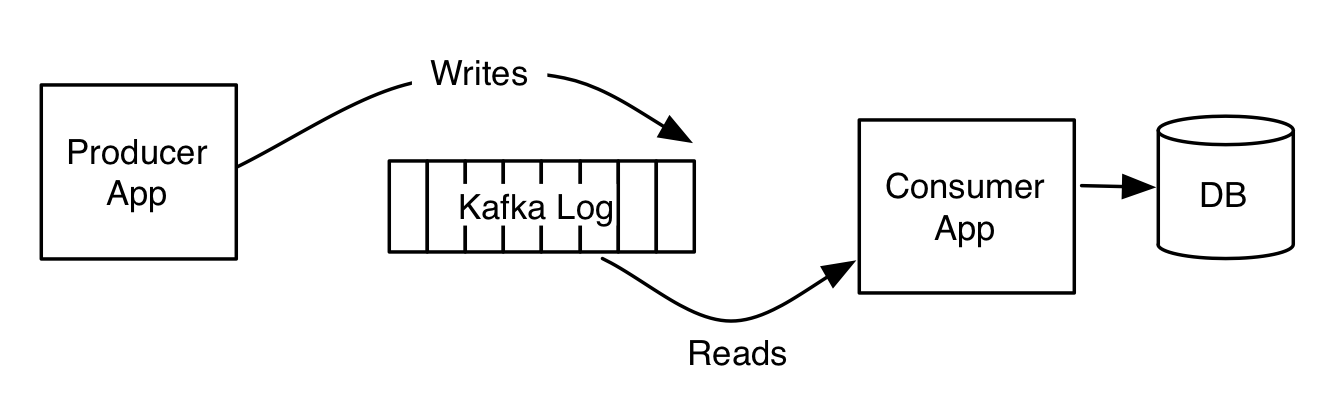

파이프라인에서 메시지가 중복 처리되는 경우, at-least-once에 해당하는 경우는  2가지가 있다.

### **Producer-Broker 사이의 ack 소실**
- Producer는 Broker에 메시지를 전송하고 ack를 수신받는다. 
- 만약 네트워크 상에서 ack가 소실/지연되어 수신받는데에 실패할 경우, Producer는 메시지 전송이 실패했다고 판단하여 재전송하게 된다. 
- 즉, 동일한 메시지가 중복 전송될 수 있다.

### **Consumer side의 offset 갱신 실패**
- Consumer가 메시지를 읽고 DB에 저장한 후에 offset을 갱신하기 전에 장애가 발생할 경우, Consumer는 재시작되었을 때 갱신되지 않은 offset을 기준으로 메시지를 읽어오게 된다. 
- 즉, 이미 DB에 저장된 메시지를 중복으로 가져오게 된다. 
- 예시) Spark Streaming의 Receiver 기반 모델에서 WAL을 사용하는 경우





## **Producer side의 exactly-once 구현**

* Kafka는 at-least-once 방식을 지원했으나, 0.11.0.0 이상부터는 트랜잭션을 적용하여 exactly-once를 구현할 수 있다.
* Producer가 트랜잭션에서 처리한 데이터의 offset을 커밋함으로써, Consumer에 정확하게 메시지를 전달할 을 수 있다.

* Producer side에서 트랜잭션을 적용하려면 Consumer side에서도 트랜잭션 기반으로 메시지를 읽어야 한다.
* Consumer 에도 트랜잭션 API를 적용해야 한다.



### **Transaction API in Producer**

```java
KafkaProducer<String, String> producer = new KafkaProducer<>(configs);
ProducerRecord<String, String> record = new ProducerRecord<>(TOPIC_NAME, "data");

producer.initTransactions();  // 트랜잭션 준비

producer.beginTransaction();  // 트랜잭션 시작
producer.send(record);        // 메시지 전송
producer.flush();
producer.commitTransaction(); // 트랜잭션 커밋

producer.close();
```

- initTransactions()로 트랜잭션을 준비한다.
- beginTransaction()과 commitTransaction() 사이에 send() 메소드가 위치하여 전송된 메시지가 커밋되도록 한다.





### **Transaction API in Consumer**

```java
configs.put(ConsumerConfig.ENABLE_AUTO_COMMIT_CONFIG, false);           // 명시적 오프셋 커밋
configs.put(ConsumerConfig.ISOLATION_LEVEL_CONFIG, "read_committed");   // 커밋된 메시지만 읽기

KafkaConsumer<String, String> consumer = new KafkaConsumer<>(configs);
consumer.subscribe(Arrays.asList(TOPIC_NAME));

while (true) {
  ConsumerRecords<String, String> records = consumer.poll(Duration.ofSeconds(1));
  for (ConsumerRecord<String, String> record : records) {
    logger.info("{}", record.toString());
  }
  consumer.commitSync();
}
```

- ```ISOLATION_LEVEL_CONFIG``` 옵션을 ```read_committed```로 설정하여 트랜잭션이 완벽하게 완료된 메시지만 읽어온다.



### **Transaction status**

```bash
$ ./kafka-console-consumer.sh --consumer.config consumer.config --formatter "kafka.coordinator.transaction.TransactionLog\$TransactionLogMessageFormatter" --bootstrap-server localhost:9092 --topic __transaction_state --from-beginning
13c2df10-1a3c-4024-b28d-d155e24b941a::TransactionMetadata(transactionalId=13c2df10-1a3c-4024-b28d-d155e24b941a, producerId=1000, producerEpoch=28, txnTimeoutMs=60000, state=Ongoing, pendingState=None, topicPartitions=Set(test-1), txnStartTimestamp=1594967312702, txnLastUpdateTimestamp=1594967312702)
13c2df10-1a3c-4024-b28d-d155e24b941a::TransactionMetadata(transactionalId=13c2df10-1a3c-4024-b28d-d155e24b941a, producerId=1000, producerEpoch=28, txnTimeoutMs=60000, state=PrepareCommit, pendingState=None, topicPartitions=Set(test-1), txnStartTimestamp=1594967312702, txnLastUpdateTimestamp=1594967312712)
13c2df10-1a3c-4024-b28d-d155e24b941a::TransactionMetadata(transactionalId=13c2df10-1a3c-4024-b28d-d155e24b941a, producerId=1000, producerEpoch=28, txnTimeoutMs=60000, state=CompleteCommit, pendingState=None, topicPartitions=Set(), txnStartTimestamp=1594967312702, txnLastUpdateTimestamp=1594967312713)
```

- ```__transaction_state``` 토픽은 Producer가 전송한 각 트랜잭션의 상태 정보를 기록하며 Consumer가 이 정보를 참조한다.
- 트랜잭션의 상태가 ```Ongoing``` -> ```PrepareCommit``` -> ```CompleteCommit```순서로 갱신된다.
- 커밋 완료 상태의 트랜잭션에 대해서만 메시지를 읽어올 수 있다.





### **Broker offset**

```bash
$ ./kafka-dump-log.sh --files /path/to/kafka/kafka_2.12-2.5.0/data/test-1/00000000000000000000.log --deep-iteration
baseOffset: 16 lastOffset: 16 count: 1 baseSequence: 0 lastSequence: 0 producerId: 1000 producerEpoch: 21 partitionLeaderEpoch: 0 isTransactional: true isControl: false position: 1680 CreateTime: 1594965813907 size: 122 magic: 2 compresscodec: NONE crc: 3909138376 isvalid: true
| offset: 16 CreateTime: 1594965813907 keysize: -1 valuesize: 54 sequence: 0 headerKeys: []
baseOffset: 17 lastOffset: 17 count: 1 baseSequence: -1 lastSequence: -1 producerId: 1000 producerEpoch: 21 partitionLeaderEpoch: 0 isTransactional: true isControl: true position: 1802 CreateTime: 1594965813942 size: 78 magic: 2 compresscodec: NONE crc: 3102183917 isvalid: true
| offset: 17 CreateTime: 1594965813942 keysize: 4 valuesize: 6 sequence: -1 headerKeys: [] endTxnMarker: COMMIT coordinatorEpoch: 0
```

- 위 예시에선 토픽의 특정 파티션에 메시지가 입력되어 16번, 17번 offset에 각각 기록되었다. 

  |             | isTransactional | isControl | endTxnMarker |
  | ----------- | --------------- | --------- | ------------ |
  | 16번 offset | true            | false     | -            |
  | 17번 offset | true            | true      | COMMIT       |

- Producer는 메시지를 전송하고(16번 offset) 트랜잭션이 완료되면 COMMIT 메시지를 입력한다(17번 offset).

- 즉, 한 트랜잭션에 대해 실제 메시지와 COMMIT 메시지를 위해 offset이 2개 소모되었다.

- Consumer는 데이터를 가져갈 때 **트랜잭션의 실제 데이터인 16번 offset만 가져가고, COMMIT 명시 데이터인 17번 offset은 무시**한다.



<br>



## **Consumer side의 exactly-once 구현**

- Consumer에서 메시지를 읽고 나서 **DB에 저장하는 단계**와 **offset을 갱신하는 단계** 사이에서 장애가 발생할 경우에 메시지 중복 처리가 발생한다.
- Kafka + Spark Streaming Integration의 Receiver-based Approach  [link](https://github.com/dhkdn9192/data_engineer_should_know/blob/master/interview/hadoop/kafka_sparkstreaming_integration.md)에선 Receiver와 WAL을 제거하고 directStream 및 자체 offset checkpoint (with HDFS/HBase)를 사용하여 동일 메시지를 중복으로 읽지 않도록 할 수 있다.



## **Conclusion**

- Kafka는 0.11.0.0 버전부터 트랜잭션을 이용한 exactly-once를 지원하게 되었다.
- offset 소모, 약간의 성능저하 등 일정 부분을 희생한 trade-off가 존재한다.
- 파이프라인 전체에 대해 exactly-once를 지원하려면 Kafka 외부의 애플리케이션단에서도 중복 처리 이슈까지 해결되어야 한다. (예: Spark Streaming의 Receiver-based Approach 이슈)
- 데이터 처리에 있어 동일 데이터의 중복이 허용되지 않는 경우엔 exactly-once가 필수적이나, 그렇지 않은 경우에는 기존의 at-least-once를 사용하면 된다.
